# Data collection & Valuation -Tether

# Tether Market Data 

In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta

# Set the date range for the past 2 years
end_date = datetime.now().date()
start_date = end_date - timedelta(days=730)  # 730 days = 2 years

print(f"Attempting to fetch data from {start_date} to {end_date}")

try:
    # Fetch USDT-USD data
    tether = yf.Ticker("USDT-USD")
    data = tether.history(start=start_date, end=end_date)

    # Calculate price deviation
    data['price_deviation'] = abs(data['Close'] - 1)

    # Rename columns to match our previous format
    data = data.rename(columns={
        'Close': 'price',
        'Volume': 'volume'
    })

    # Select and reorder columns
    data = data[['price', 'volume', 'price_deviation']]

    # Save to CSV
    data.to_csv('tether_market_data.csv')

    print(f"Data saved to tether_market_data.csv")
    print(f"Date range: from {data.index.min().date()} to {data.index.max().date()}")
    print(f"Total number of days: {len(data)}")

except Exception as e:
    print(f"An error occurred: {e}")
    print("Please check your internet connection and try again.")

Attempting to fetch data from 2022-08-21 to 2024-08-20
Data saved to tether_market_data.csv
Date range: from 2022-08-21 to 2024-08-19
Total number of days: 730


# Tether Transparency Analysis Script

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import os

# Load data with error handling
def load_csv(file_name, date_column='Date'):
    if not os.path.exists(file_name):
        print(f"Error: File {file_name} not found.")
        return None
    
    try:
        df = pd.read_csv(file_name)
        if date_column in df.columns:
            df[date_column] = pd.to_datetime(df[date_column], format='mixed', dayfirst=False)
        print(f"Successfully loaded {file_name}")
        print(f"Columns: {df.columns.tolist()}")
        print(f"First few rows:\n{df.head()}\n")
        return df
    except Exception as e:
        print(f"Error loading {file_name}: {str(e)}")
        return None

# Load data
reserve_data = load_csv('tether_reserves_quarterly.csv')
regulatory_data = load_csv('tether_regulatory_events.csv')
market_data = load_csv('tether_market_data.csv')

# Process reserve data
if reserve_data is not None:
    reserve_data['Cash_Equivalent_Percent'] = reserve_data['Cash_Equivalent_Percent'].str.rstrip('%').astype('float') / 100.0

# Process regulatory data
if regulatory_data is not None:
    if len(regulatory_data.columns) == 1:
        regulatory_data = regulatory_data[regulatory_data.columns[0]].str.split(',', expand=True)
        regulatory_data.columns = ['Date', 'Event_Type', 'Description', 'Impact_Score']
        regulatory_data['Date'] = pd.to_datetime(regulatory_data['Date'])
        regulatory_data['Impact_Score'] = regulatory_data['Impact_Score'].astype(int)

# Check if all data is loaded successfully
if reserve_data is None or regulatory_data is None or market_data is None:
    print("Error: One or more required data files could not be loaded. Please check the file names and formats.")
else:
    # Continue with the analysis
    def calculate_reserve_score(cash_equivalent_percent):
        if cash_equivalent_percent >= 0.80:
            return 5
        elif cash_equivalent_percent >= 0.70:
            return 4
        elif cash_equivalent_percent >= 0.60:
            return 3
        elif cash_equivalent_percent >= 0.50:
            return 2
        elif cash_equivalent_percent > 0:
            return 1
        return 0

    def calculate_compliance_score(events):
        return sum(events['Impact_Score'])

    # 1. Transparency Score Analysis
    def calculate_transparency_score(reserve_data, regulatory_data):
        reserve_data['R_Score'] = reserve_data['Cash_Equivalent_Percent'].apply(calculate_reserve_score)
        
        if 'Impact_Score' in regulatory_data.columns:
            regulatory_data['Quarter'] = regulatory_data['Date'].dt.to_period('Q')
            compliance_scores = regulatory_data.groupby('Quarter')['Impact_Score'].sum().reset_index()
            compliance_scores['C_Score'] = compliance_scores['Impact_Score'].clip(-5, 5)
        else:
            print("Warning: 'Impact_Score' column not found in regulatory data. Using default C_Score of 0.")
            compliance_scores = pd.DataFrame({'Quarter': reserve_data['Date'].dt.to_period('Q'), 'C_Score': 0})
        
        merged_data = pd.merge(reserve_data, compliance_scores, left_on=reserve_data['Date'].dt.to_period('Q'), right_on='Quarter', how='left')
        merged_data['C_Score'] = merged_data['C_Score'].fillna(0)
        
        w1, w2 = 0.6, 0.4  # weights for R and C
        merged_data['TS'] = w1 * merged_data['R_Score'] + w2 * merged_data['C_Score']
        
        return merged_data[['Date', 'R_Score', 'C_Score', 'TS']].sort_values('Date')

    ts_data = calculate_transparency_score(reserve_data, regulatory_data)
    print("Transparency Scores for Tether over time:")
    print(ts_data)

    # 2. Time Series Analysis
    plt.figure(figsize=(12, 6))
    plt.plot(ts_data['Date'], ts_data['TS'], marker='o')
    plt.title('Tether Transparency Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Transparency Score')
    plt.grid(True)
    plt.savefig('tether_ts_over_time.png')
    plt.close()

    # 3. Correlation Analysis
    market_data['Month'] = pd.to_datetime(market_data['Date']).dt.to_period('M')
    monthly_market_data = market_data.groupby('Month').agg({
        'price_deviation': 'mean',
        'volume': 'mean'
    }).reset_index()

    monthly_market_data['Month'] = monthly_market_data['Month'].dt.to_timestamp()
    monthly_market_data = monthly_market_data.sort_values('Month')

    merged_data = pd.merge_asof(monthly_market_data, ts_data, left_on='Month', right_on='Date', direction='nearest')

    # Ensure we have matching data points for correlation
    valid_data = merged_data.dropna(subset=['TS', 'price_deviation', 'volume'])

    if len(valid_data) > 1:
        corr_price_deviation = stats.pearsonr(valid_data['TS'], valid_data['price_deviation'])
        corr_volume = stats.pearsonr(valid_data['TS'], valid_data['volume'])

        print("\nCorrelation between TS and price deviation:", corr_price_deviation)
        print("Correlation between TS and trading volume:", corr_volume)

        # Correlation heatmap
        correlation_matrix = valid_data[['TS', 'price_deviation', 'volume']].corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title('Correlation Heatmap: TS, Price Deviation, and Volume')
        plt.savefig('tether_correlation_heatmap.png')
        plt.close()

        # Scatter plots
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        ax1.scatter(valid_data['TS'], valid_data['price_deviation'])
        ax1.set_title('TS vs Price Deviation')
        ax1.set_xlabel('Transparency Score')
        ax1.set_ylabel('Price Deviation')

        ax2.scatter(valid_data['TS'], valid_data['volume'])
        ax2.set_title('TS vs Trading Volume')
        ax2.set_xlabel('Transparency Score')
        ax2.set_ylabel('Trading Volume')

        plt.tight_layout()
        plt.savefig('tether_ts_correlations.png')
        plt.close()
    else:
        print("Not enough valid data points for correlation analysis.")

print("Analysis complete.")


Successfully loaded tether_reserves_quarterly.csv
Columns: ['Date', 'Cash_Equivalent_Percent', 'Other_Assets_Percent']
First few rows:
        Date Cash_Equivalent_Percent Other_Assets_Percent
0 2024-06-30                  84.24%               15.76%
1 2024-03-31                  84.05%               15.95%
2 2023-12-31                  84.59%               15.41%
3 2023-09-30                  85.74%               14.26%
4 2023-06-30                  85.05%               14.95%

Successfully loaded tether_regulatory_events.csv
Columns: ['Date,Event_Type,Description,Impact_Score']
First few rows:
            Date,Event_Type,Description,Impact_Score
0  2020-04-16,Legal_Action,Lawsuit filed against ...
1  2020-09-02,Policy_Change,Tether moves part of ...
2  2021-01-13,Legal_Action,Tether executives repo...
3  2021-02-23,Legal_Action,Tether settles with NY...
4  2021-05-13,Audit_Result,Tether releases breakd...

Successfully loaded tether_market_data.csv
Columns: ['Date', 'price', 'volume'

/var/folders/vr/qmj2p25s2fx28r_yqxgxctjm0000gn/T/ipykernel_13958/1020189248.py:98: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  market_data['Month'] = pd.to_datetime(market_data['Date']).dt.to_period('M')


# Tether Advanced Analysis and Visualization Script

TS Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10 entries, 2022-03-31 to 2024-06-30
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   R_Score  10 non-null     int64  
 1   C_Score  10 non-null     float64
 2   TS       10 non-null     float64
dtypes: float64(2), int64(1)
memory usage: 320.0 bytes
None

Merged Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25 entries, 2022-06-30 to 2024-06-30
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Month            25 non-null     datetime64[ns]
 1   price_deviation  25 non-null     float64       
 2   volume           25 non-null     float64       
 3   R_Score          25 non-null     int64         
 4   C_Score          25 non-null     float64       
 5   TS               25 non-null     float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
m

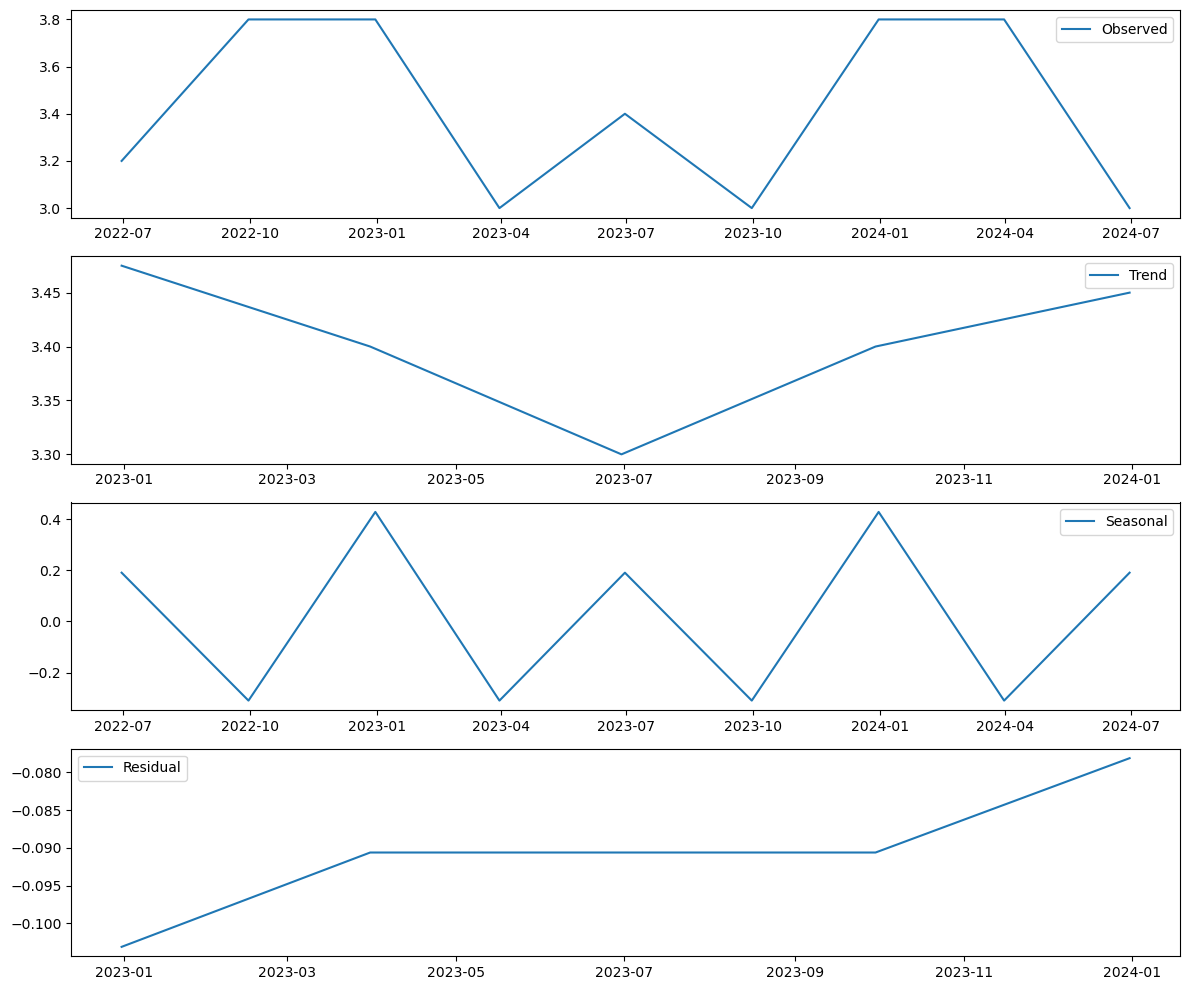

TypeError: 'NoneType' object is not callable

In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf
from scipy import stats

def preprocess_data(ts_data, merged_data):
    print("TS Data Info:")
    print(ts_data.info())
    print("\nMerged Data Info:")
    print(merged_data.info())
    
    print("\nTS Data Head:")
    print(ts_data.head())
    print("\nMerged Data Head:")
    print(merged_data.head())
    
    # Ensure index is datetime
    if not isinstance(ts_data.index, pd.DatetimeIndex):
        ts_data.index = pd.to_datetime(ts_data.index)
    if not isinstance(merged_data.index, pd.DatetimeIndex):
        merged_data.index = pd.to_datetime(merged_data.index)
    
    ts_data.sort_index(inplace=True)
    merged_data.sort_index(inplace=True)
    
    # Aggregate market data to quarterly frequency
    merged_data_quarterly = merged_data.resample('Q').mean()
    
    # Rename columns in merged_data to match ts_data
    merged_data_quarterly = merged_data_quarterly.rename(columns={
        'price_deviation': 'Price_Deviation',
        'volume': 'Volume'
    })
    
    # Align the dates
    aligned_data = pd.merge(ts_data, merged_data_quarterly[['Price_Deviation', 'Volume']], 
                            left_index=True, right_index=True, how='inner')
    
    print("\nAligned Data Info:")
    print(aligned_data.info())
    print("\nAligned Data Head:")
    print(aligned_data.head())
    
    return aligned_data

def time_series_analysis(data):
    # Decompose the time series
    decomposition = seasonal_decompose(data['TS'], model='additive', period=4)  # Assuming quarterly data
    
    plt.figure(figsize=(12, 10))
    plt.subplot(411)
    plt.plot(data.index, data['TS'], label='Observed')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(data.index, decomposition.trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(data.index, decomposition.seasonal, label='Seasonal')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(data.index, decomposition.resid, label='Residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.show()('ts_decomposition.png')
    plt.close()

    print("Time Series Decomposition:")
    print(f"Trend: {decomposition.trend.iloc[-1]:.4f}")
    print(f"Seasonality: {decomposition.seasonal.iloc[-1]:.4f}")
    print(f"Residual: {decomposition.resid.iloc[-1]:.4f}")

def lag_analysis(data):
    # Calculate cross-correlation
    cc_price_deviation = ccf(data['TS'], data['Price_Deviation'], adjusted=False)
    cc_volume = ccf(data['TS'], data['Volume'], adjusted=False)
    
    lags = range(len(cc_price_deviation))
    
    plt.figure(figsize=(12, 6))
    plt.plot(lags, cc_price_deviation, label='Price Deviation')
    plt.plot(lags, cc_volume, label='Volume')
    plt.title('Cross-correlation of TS with Price Deviation and Volume')
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.legend()
    plt.show()('cross_correlation.png')
    plt.close()
    
    print("\nLag Analysis:")
    print(f"Max correlation with Price Deviation at lag {np.argmax(np.abs(cc_price_deviation))}")
    print(f"Max correlation with Volume at lag {np.argmax(np.abs(cc_volume))}")

def component_analysis(data):
    # Correlations of R_Score and C_Score with market indicators
    corr_r_price = stats.pearsonr(data['R_Score'], data['Price_Deviation'])
    corr_c_price = stats.pearsonr(data['C_Score'], data['Price_Deviation'])
    corr_r_volume = stats.pearsonr(data['R_Score'], data['Volume'])
    corr_c_volume = stats.pearsonr(data['C_Score'], data['Volume'])
    
    print("\nComponent Analysis:")
    print(f"Correlation of R_Score with Price Deviation: {corr_r_price[0]:.4f} (p-value: {corr_r_price[1]:.4f})")
    print(f"Correlation of C_Score with Price Deviation: {corr_c_price[0]:.4f} (p-value: {corr_c_price[1]:.4f})")
    print(f"Correlation of R_Score with Volume: {corr_r_volume[0]:.4f} (p-value: {corr_r_volume[1]:.4f})")
    print(f"Correlation of C_Score with Volume: {corr_c_volume[0]:.4f} (p-value: {corr_c_volume[1]:.4f})")

def create_visualizations(data):
    # Line graph: TS over time
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['TS'], marker='o')
    plt.title('Tether Transparency Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Transparency Score')
    plt.grid(True)
    plt.show()('ts_over_time.png')
    plt.close()

    # Scatter plot: TS vs. price deviation from peg
    plt.figure(figsize=(10, 6))
    plt.scatter(data['TS'], data['Price_Deviation'])
    plt.title('Transparency Score vs Price Deviation')
    plt.xlabel('Transparency Score')
    plt.ylabel('Price Deviation from Peg')
    plt.show()('ts_vs_price_deviation.png')
    plt.close()

    # Bar chart: Components of TS (R and C) for each period
    data_reset = data.reset_index()
    data_reset['Date'] = data_reset['Date'].dt.strftime('%Y-%m')
    
    plt.figure(figsize=(12, 6))
    width = 0.35
    x = range(len(data_reset))
    plt.bar(x, data_reset['R_Score'], width, label='R Score')
    plt.bar([i + width for i in x], data_reset['C_Score'], width, label='C Score')
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.title('Components of Transparency Score')
    plt.xticks([i + width/2 for i in x], data_reset['Date'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()('ts_components.png')
    plt.close()

# Preprocess and align data
aligned_data = preprocess_data(ts_data, merged_data)

# Run all analyses
time_series_analysis(aligned_data)
lag_analysis(aligned_data)
component_analysis(aligned_data)
create_visualizations(aligned_data)

print("All analyses and visualizations completed.")

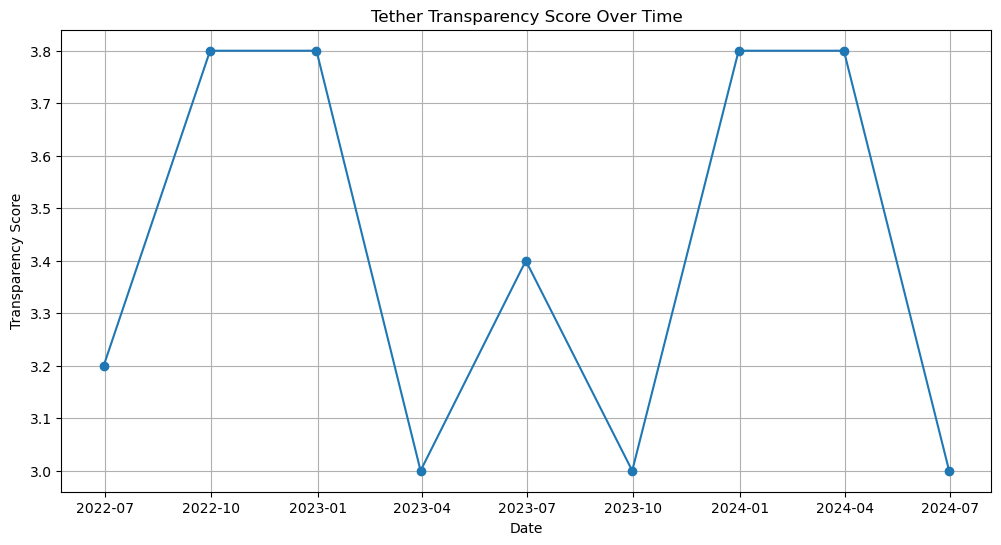

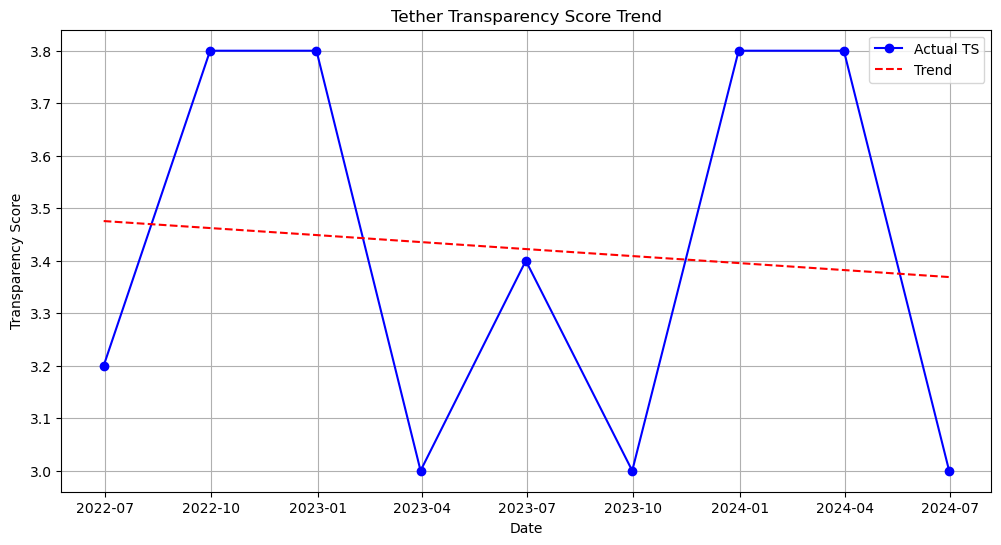

Time Series Analysis:
Trend slope: -0.0133
Trend intercept: 3.4756


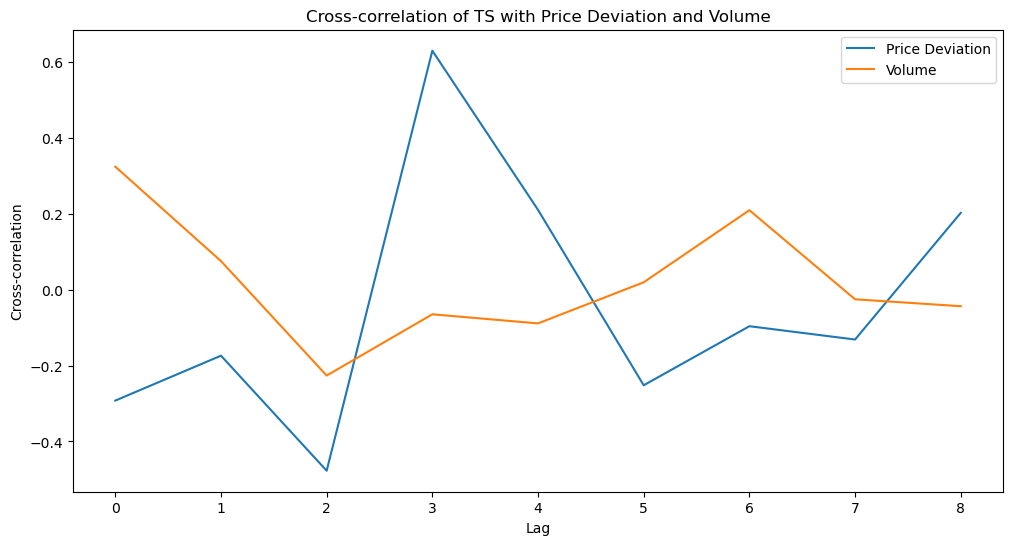


Lag Analysis:
Max correlation with Price Deviation at lag 3
Max correlation with Volume at lag 0

Component Analysis:
Correlation of R_Score with Price Deviation: 0.5480 (p-value: 0.1266)
Correlation of C_Score with Price Deviation: -0.5678 (p-value: 0.1108)
Correlation of R_Score with Volume: -0.1170 (p-value: 0.7644)
Correlation of C_Score with Volume: 0.3776 (p-value: 0.3163)


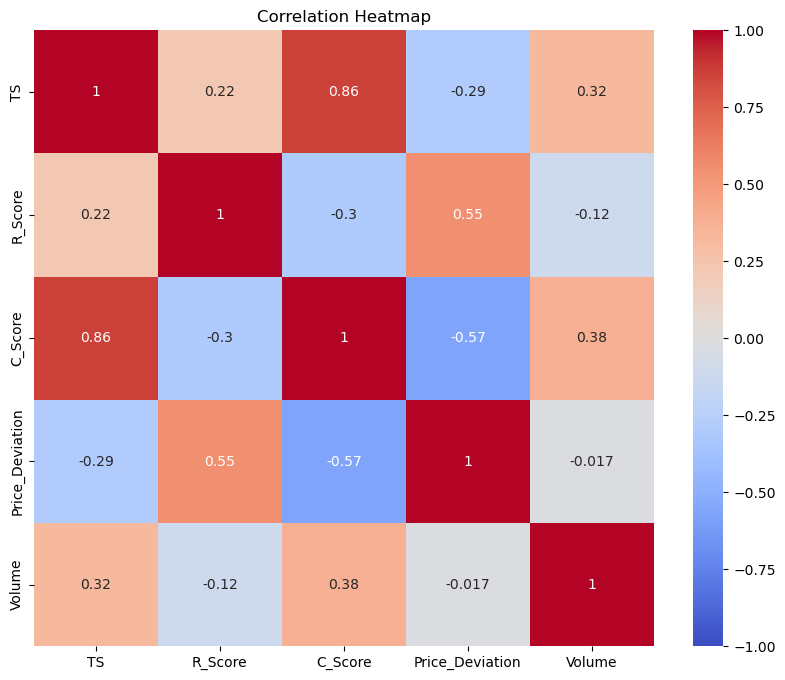

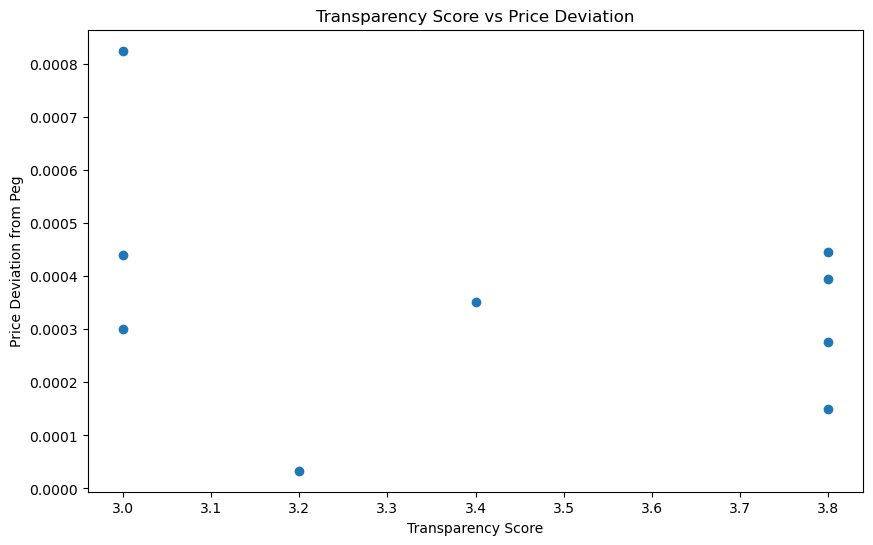

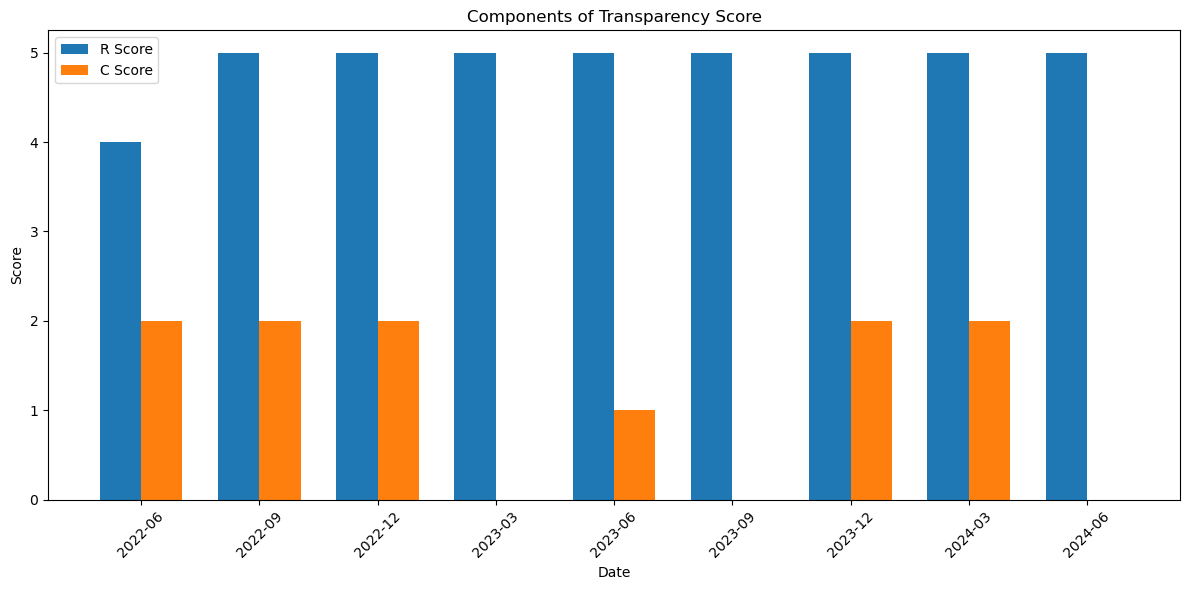

All analyses and visualizations completed.


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import ccf
from scipy import stats

def preprocess_data(ts_data, merged_data):
    # [Previous preprocessing code remains the same]
    # ...

    return aligned_data

def time_series_analysis(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['TS'], marker='o')
    plt.title('Tether Transparency Score Over Time')
    plt.xlabel('Date')
    plt.ylabel('Transparency Score')
    plt.grid(True)
    plt.show()

    # Simple trend analysis
    x = np.arange(len(data))
    y = data['TS'].values
    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['TS'], 'bo-', label='Actual TS')
    plt.plot(data.index, p(x), 'r--', label='Trend')
    plt.title('Tether Transparency Score Trend')
    plt.xlabel('Date')
    plt.ylabel('Transparency Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    print("Time Series Analysis:")
    print(f"Trend slope: {z[0]:.4f}")
    print(f"Trend intercept: {z[1]:.4f}")

def lag_analysis(data):
    # Calculate cross-correlation
    cc_price_deviation = ccf(data['TS'], data['Price_Deviation'], adjusted=False)
    cc_volume = ccf(data['TS'], data['Volume'], adjusted=False)
    
    lags = range(len(cc_price_deviation))
    
    plt.figure(figsize=(12, 6))
    plt.plot(lags, cc_price_deviation, label='Price Deviation')
    plt.plot(lags, cc_volume, label='Volume')
    plt.title('Cross-correlation of TS with Price Deviation and Volume')
    plt.xlabel('Lag')
    plt.ylabel('Cross-correlation')
    plt.legend()
    plt.show()
    
    print("\nLag Analysis:")
    print(f"Max correlation with Price Deviation at lag {np.argmax(np.abs(cc_price_deviation))}")
    print(f"Max correlation with Volume at lag {np.argmax(np.abs(cc_volume))}")

def component_analysis(data):
    # Correlations of R_Score and C_Score with market indicators
    corr_r_price = stats.pearsonr(data['R_Score'], data['Price_Deviation'])
    corr_c_price = stats.pearsonr(data['C_Score'], data['Price_Deviation'])
    corr_r_volume = stats.pearsonr(data['R_Score'], data['Volume'])
    corr_c_volume = stats.pearsonr(data['C_Score'], data['Volume'])
    
    print("\nComponent Analysis:")
    print(f"Correlation of R_Score with Price Deviation: {corr_r_price[0]:.4f} (p-value: {corr_r_price[1]:.4f})")
    print(f"Correlation of C_Score with Price Deviation: {corr_c_price[0]:.4f} (p-value: {corr_c_price[1]:.4f})")
    print(f"Correlation of R_Score with Volume: {corr_r_volume[0]:.4f} (p-value: {corr_r_volume[1]:.4f})")
    print(f"Correlation of C_Score with Volume: {corr_c_volume[0]:.4f} (p-value: {corr_c_volume[1]:.4f})")

    # Visualization of correlations
    corr_matrix = data[['TS', 'R_Score', 'C_Score', 'Price_Deviation', 'Volume']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
    plt.title('Correlation Heatmap')
    plt.show()

def create_visualizations(data):
    # Scatter plot: TS vs. price deviation from peg
    plt.figure(figsize=(10, 6))
    plt.scatter(data['TS'], data['Price_Deviation'])
    plt.title('Transparency Score vs Price Deviation')
    plt.xlabel('Transparency Score')
    plt.ylabel('Price Deviation from Peg')
    plt.show()

    # Bar chart: Components of TS (R and C) for each period
    data_reset = data.reset_index()
    data_reset['Date'] = data_reset['Date'].dt.strftime('%Y-%m')
    
    plt.figure(figsize=(12, 6))
    width = 0.35
    x = range(len(data_reset))
    plt.bar(x, data_reset['R_Score'], width, label='R Score')
    plt.bar([i + width for i in x], data_reset['C_Score'], width, label='C Score')
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.title('Components of Transparency Score')
    plt.xticks([i + width/2 for i in x], data_reset['Date'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Preprocess and align data
aligned_data = preprocess_data(ts_data, merged_data)

# Run all analyses
time_series_analysis(aligned_data)
lag_analysis(aligned_data)
component_analysis(aligned_data)
create_visualizations(aligned_data)

print("All analyses and visualizations completed.")


# Mixed Methods Integration Script for Tether Analysis

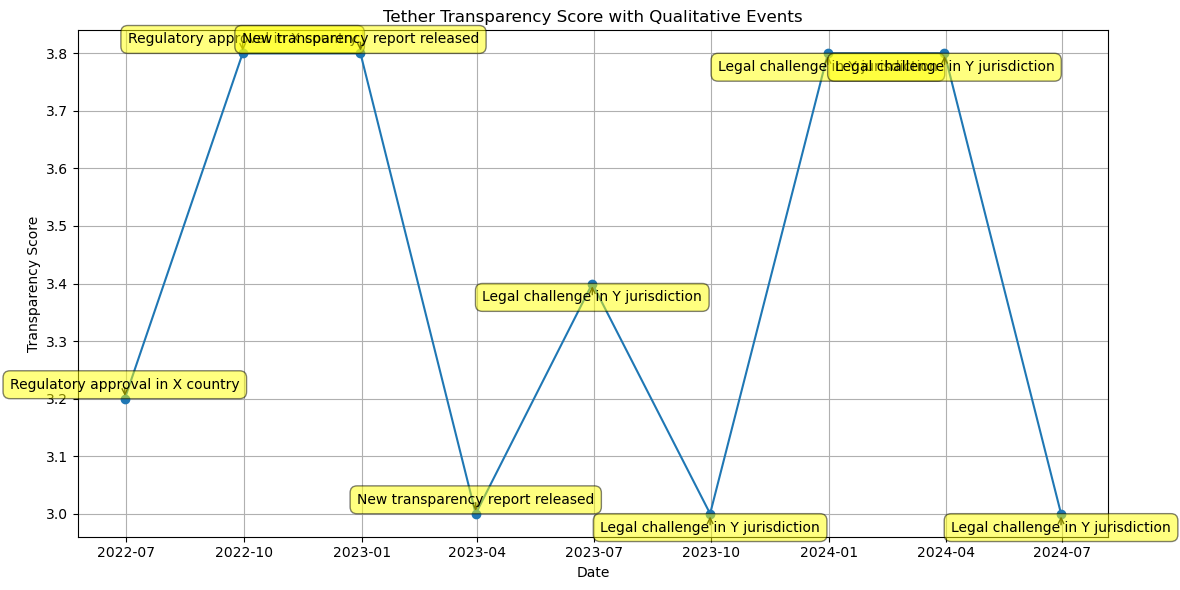

Impact of events on Transparency Score:
        mean       std
impact                
-1      3.40  0.400000
 1      3.45  0.412311

T-test results: t-statistic = 0.18389242812245785, p-value = 0.8593114497467743
Significant changes in Transparency Score with context:

Date: 2023-03-31 00:00:00
TS Change: -0.80
Context: New transparency report released

Date: 2023-12-31 00:00:00
TS Change: 0.80
Context: Legal challenge in Y jurisdiction

Date: 2024-06-30 00:00:00
TS Change: -0.80
Context: Legal challenge in Y jurisdiction
Comparison of original and refined TS:
             TS  Refined_TS
count  9.000000    9.000000
mean   3.422222    3.788889
std    0.380058    0.314024
min    3.000000    3.400000
25%    3.000000    3.500000
50%    3.400000    3.800000
75%    3.800000    4.100000
max    3.800000    4.100000


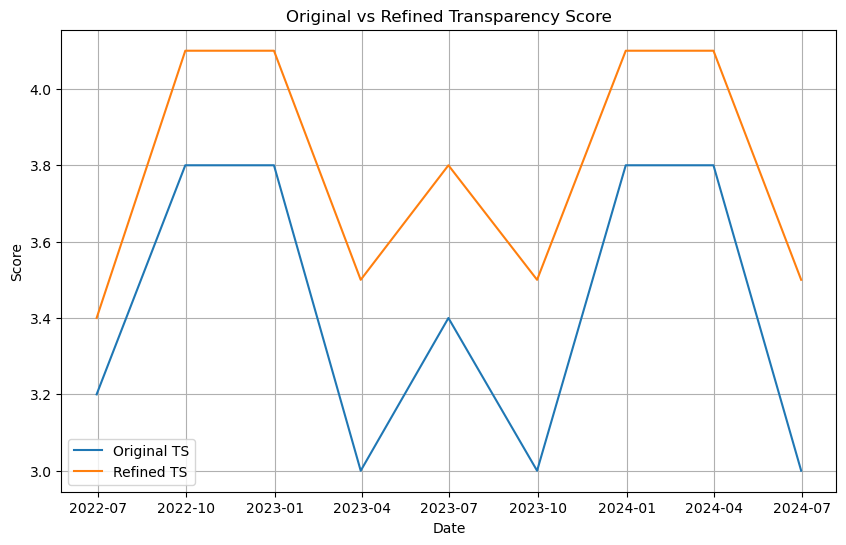

In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# Assume 'aligned_data' is your existing DataFrame with quantitative data

# 1. Qualitative Data Integration
def add_qualitative_events(data):
    # Define significant events
    events = [
        {'date': '2022-09-15', 'event': 'Regulatory approval in X country', 'impact': 1},
        {'date': '2023-03-01', 'event': 'New transparency report released', 'impact': 1},
        {'date': '2023-07-10', 'event': 'Legal challenge in Y jurisdiction', 'impact': -1},
        # Add more events as needed
    ]
    
    events_df = pd.DataFrame(events)
    events_df['date'] = pd.to_datetime(events_df['date'])
    events_df.set_index('date', inplace=True)
    
    # Merge events with quantitative data
    return pd.merge_asof(data, events_df, left_index=True, right_index=True, direction='nearest')

# 2. Visualization with Qualitative Insights
def plot_ts_with_events(data):
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['TS'], marker='o')
    
    for idx, row in data.iterrows():
        if pd.notnull(row['event']):
            plt.annotate(row['event'], (idx, row['TS']),
                         xytext=(0, 10 if row['impact'] > 0 else -10),
                         textcoords='offset points',
                         ha='center', va='center',
                         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
                         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))
    
    plt.title('Tether Transparency Score with Qualitative Events')
    plt.xlabel('Date')
    plt.ylabel('Transparency Score')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# 3. Impact Analysis
def analyze_event_impact(data):
    event_impact = data.groupby('impact')['TS'].agg(['mean', 'std'])
    print("Impact of events on Transparency Score:")
    print(event_impact)
    
    # T-test for significant difference
    positive_impact = data[data['impact'] == 1]['TS']
    negative_impact = data[data['impact'] == -1]['TS']
    t_stat, p_value = stats.ttest_ind(positive_impact, negative_impact)
    print(f"\nT-test results: t-statistic = {t_stat}, p-value = {p_value}")

# 4. Qualitative Context for Quantitative Findings
def provide_context(data):
    # Example: Explain unusual changes in TS
    ts_changes = data['TS'].diff()
    significant_changes = data[abs(ts_changes) > ts_changes.std()]
    
    print("Significant changes in Transparency Score with context:")
    for date, row in significant_changes.iterrows():
        print(f"\nDate: {date}")
        print(f"TS Change: {ts_changes[date]:.2f}")
        if pd.notnull(row['event']):
            print(f"Context: {row['event']}")
        else:
            print("No specific event recorded for this change.")

# 5. Iterative Refinement (example)
def refine_ts_calculation(data):
    # Example: Adjust weights based on qualitative insights
    w1, w2 = 0.7, 0.3  # New weights for R_Score and C_Score
    data['Refined_TS'] = w1 * data['R_Score'] + w2 * data['C_Score']
    
    print("Comparison of original and refined TS:")
    print(data[['TS', 'Refined_TS']].describe())
    
    # Visualize comparison
    plt.figure(figsize=(10, 6))
    plt.plot(data.index, data['TS'], label='Original TS')
    plt.plot(data.index, data['Refined_TS'], label='Refined TS')
    plt.title('Original vs Refined Transparency Score')
    plt.xlabel('Date')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# Main execution
aligned_data_with_events = add_qualitative_events(aligned_data)
plot_ts_with_events(aligned_data_with_events)
analyze_event_impact(aligned_data_with_events)
provide_context(aligned_data_with_events)
refine_ts_calculation(aligned_data_with_events)